# Compute Proponents/Opponents with Tracin

In [1]:
!/home/khmt/anaconda3/envs/soups-for-testing/bin/python --version

Python 3.10.18


In [2]:
%cd /home/khmt/Documents/TQKhangT/mthien/soups

/home/khmt/Documents/TQKhangT/mthien/soups


/home/khmt/anaconda3/envs/soups-for-testing/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import packages

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import json
import os
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
import torch
import torch.nn as nn
from torch import Tensor
import torchvision
from captum.influence import TracInCPFast
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

import soups.utils as utils
from soups.opts import add_self_influence_opts
from soups.utils.logger import init_logger, logger
from soups.utils.training import infer_final_fc, make_model

/home/khmt/anaconda3/envs/soups-for-testing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [5]:
def checkpoints_load_func(model: nn.Module, checkpoint_path: str, device: torch.device) -> float:
    """
    When this function is used in TracInCP implementations, this function should
    return the learning rate at the checkpoint. However, if that learning rate
    is not available, it is safe to simply return 1, as we do, because it turns
    out TracInCP implementations are not sensitive to that learning rate.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return 1.0


def plot_accuracies(predicted: list[bool], show: bool = False) -> None:
    plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(8, 6))
    increasing_scores_accuracies = []
    decreasing_scores_accuracies = []

    num_corrects = 0
    for i in range(len(predicted)):
        num_corrects += int(predicted[i])
        increasing_scores_accuracies.append(num_corrects / (i + 1))

    num_corrects = 0
    for i in range(len(predicted)):
        num_corrects += int(predicted[-i - 1])
        decreasing_scores_accuracies.append(num_corrects / (i + 1))

    plt.plot(increasing_scores_accuracies, label='Increasing self-influence scores', color='blue')
    plt.plot(decreasing_scores_accuracies, label='Decreasing self-influence scores', color='red')
    plt.xlabel('Number of examples considered')
    plt.ylabel('Cumulative Accuracy')

    plt.title('Model Accuracy vs Self-influence Score Order')
    plt.legend()
    plt.grid(True)

    # logger.info('Saved accuracies plot to ./accuracies.png')
    # plt.savefig('./accuracies.png', dpi=300, bbox_inches='tight')

    if show:
        plt.show()

## TracIn

### Config

In [6]:
seed: int = 42
device_str: str = 'cpu'
output_file: str = './tracin_results.json'
model_name: str = 'timm/caformer_s36.sail_in22k_ft_in1k'
checkpoint_path_list: list[str] = [
    '/home/khmt/Documents/TQKhangT/mthien/soups/checkpoints-sync/2025-09-01_16-22-06-caformer_s36/f1/model_epoch_16_f1_0.7191.pth'
]
dataset_dir: str = './data/ich-split-renamed'
eval_batch_size: int = 8
num_workers: int = 1
max_num_train_samples = 1000
max_num_test_samples = 5

### Setup

In [7]:
init_logger(compact=True)

utils.set_seed(seed)
logger.info(f'Seed: {seed}')

if os.path.isfile(output_file):
    raise FileExistsError(f'Output file already exists: {output_file}')
os.makedirs(os.path.dirname(output_file), exist_ok=True)

if device_str == 'auto':
    device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

logger.info(f'Using device: {device_str}')

# find all model checkpoint files
checkpoint_paths: list[str] = []
for checkpoint_path in checkpoint_path_list:
    if os.path.isfile(checkpoint_path) and checkpoint_path.endswith('.pth'):
        checkpoint_paths.append(checkpoint_path)
    elif os.path.isdir(checkpoint_path):
        checkpoint_paths.extend(
            os.path.join(checkpoint_path, f)
            for f in os.listdir(checkpoint_path)
            if f.endswith('.pth')
        )

if not checkpoint_paths:
    logger.error('No model checkpoints found.')
    exit(1)

logger.info(
    f'Found total {len(checkpoint_paths)} model checkpoints for calculating self-influence'
)

2025-09-16 13:47:14.594 | INFO     | 1535108138:4 - Seed: 42
2025-09-16 13:47:14.595 | INFO     | 1535108138:14 - Using device: cpu
2025-09-16 13:47:14.595 | INFO     | 1535108138:32 - Found total 1 model checkpoints for calculating self-influence


### Loading data and model

In [8]:
# load dataset
normalize_transform = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

inverse_normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0.0, 0.0, 0.0], std=[1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
    ),
    torchvision.transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    normalize_transform,
])
eval_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    normalize_transform,
])

train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'train'),
    transform=train_transforms,
)
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'test'),
    transform=eval_transforms,
)
label_to_class = test_dataset.classes
num_classes = len(label_to_class)

train_dataset = torch.utils.data.Subset(
    dataset=train_dataset,
    indices=np.random.choice(
        len(train_dataset), min(len(train_dataset), max_num_train_samples), replace=False
    ),  # pyright: ignore[reportArgumentType]
)

test_dataset = torch.utils.data.Subset(
    dataset=test_dataset,
    indices=np.random.choice(
        len(test_dataset), min(len(test_dataset), max_num_test_samples), replace=False
    ),  # pyright: ignore[reportArgumentType]
)


train_data_loader = DataLoader(
    train_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    # num_workers=num_workers,
)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    # num_workers=num_workers,
)
logger.info(f'{len(train_data_loader) = }, {len(test_data_loader) = }')

2025-09-16 13:47:18.367 | INFO     | 3271701808:64 - len(train_data_loader) = 125, len(test_data_loader) = 1


In [9]:
# loading model
model = make_model(
    model_name=model_name,
    num_classes=num_classes,
).to(device)
model.eval()

final_fc_layer = infer_final_fc(model=model)
assert isinstance(final_fc_layer, nn.Linear)
logger.debug(f'final_fc_layer: {final_fc_layer = }')

2025-09-16 13:47:22.059 | DEBUG    | 1541995813:10 - final_fc_layer: final_fc_layer = Linear(in_features=2048, out_features=17, bias=True)


### Compute TracIn scores

In [10]:
tracin_cp_fast = TracInCPFast(
    model=model,
    final_fc_layer=final_fc_layer,
    train_dataset=train_data_loader,
    checkpoints=checkpoint_paths,
    checkpoints_load_func=partial(checkpoints_load_func, device=device),
    loss_fn=nn.CrossEntropyLoss(reduction='sum'),
)

#### Self-influence scores

In [11]:
start_time = datetime.now()
logger.info('Start computing self-influence scores...')
self_influence_scores = tracin_cp_fast.self_influence(show_progress=True)
total_minutes = (datetime.now() - start_time).total_seconds() / 60.0
print(
    'computed self influence scores for %d examples in %.2f minutes'
    % (len(self_influence_scores), total_minutes)
)

2025-09-16 13:47:25.212 | INFO     | 2942097534:2 - Start computing self-influence scores...


Using TracInCPFast to compute self influence. Processing batch:   0%|                                                                                       | 0/125 [00:00<?, ?it/s]

Using TracInCPFast to compute self influence. Processing batch: 100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [00:36<00:00,  3.38it/s]

computed self influence scores for 1000 examples in 0.62 minutes


In [12]:
self_influence_scores_list: list[float] = self_influence_scores.detach().cpu().tolist()
sorted_score_indices = sorted(
    range(len(self_influence_scores_list)),
    key=lambda i: self_influence_scores_list[i],
)

Calculating accuracies for train : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.63 samples/s]

2025-09-16 13:52:05.352 | INFO     | 2785996145:27 - Train accuracy for 1000 samples: 0.9210


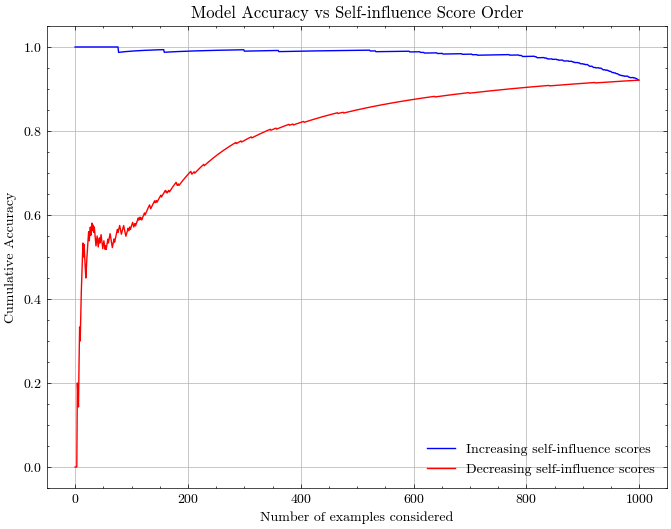

In [15]:
train_predicted: list[bool] = []
with torch.no_grad():
    model.to(device)
    checkpoints_load_func(model=model, checkpoint_path=checkpoint_paths[0], device=device)
    model.eval()

    for idx in tqdm(sorted_score_indices, desc='Calculating accuracies for train ', unit=' samples'):
    # train_iter = tqdm(
    #     range(0, len(sorted_score_indices), eval_batch_size),
    #     desc='Calculating accuracies',
    # )
    # for i in train_iter:
        # start_index = i
        # end_index = min(len(sorted_score_indices), i + eval_batch_size)
        # batch_indices = sorted_score_indices[start_index:end_index]
        # images = torch.stack([train_dataset[idx][0] for idx in batch_indices], dim=0).to(device)
        # labels = torch.tensor([train_dataset[idx][1] for idx in batch_indices], device=device)
        image, label = train_dataset[idx]
        images = image.unsqueeze(0).to(device)
        labels = torch.tensor([label], device=device, dtype=torch.int64)

        logits = model(images)
        predictions = logits.argmax(dim=1)
        train_predicted.extend((predictions == labels).tolist())

train_accuracy = sum(train_predicted) / len(train_predicted)
logger.info(f'Train accuracy for {len(sorted_score_indices)} samples: {train_accuracy:0.4f}')
plot_accuracies(train_predicted)

#### Proponents and Opponents

In [16]:
test_features = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.int64)

In [21]:
k = 7
start_time = datetime.now()
proponents_indices, proponents_influence_scores = tracin_cp_fast.influence(
    inputs=(test_features, test_labels),
    k=k,
    proponents=True,
    show_progress=True,
)
opponents_indices, opponents_influence_scores = tracin_cp_fast.influence(
    inputs=(test_features, test_labels), k=k, proponents=False, show_progress=True
)
total_minutes = (datetime.now() - start_time).total_seconds() / 60.0
print(
    'Computed proponents / opponents over a dataset of %d examples in %.2f minutes'
    % (len(test_dataset), total_minutes)
)

Using TracInCPFast to perform computation for getting proponents. Processing training batches:   0%|                                                        | 0/125 [00:00<?, ?it/s]

Using TracInCPFast to perform computation for getting proponents. Processing training batches: 100%|██████████████████████████████████████████████| 125/125 [00:54<00:00,  2.30it/s]
Using TracInCPFast to perform computation for getting opponents. Processing training batches: 100%|███████████████████████████████████████████████| 125/125 [00:54<00:00,  2.28it/s]

Computed proponents / opponents over a dataset of 5 examples in 1.82 minutes


In [25]:
def imshow_transform(tensor_in_dataset: Tensor) -> Tensor:
    return inverse_normalize_transform(tensor_in_dataset.squeeze()).permute(1, 2, 0)


def display_test_example(
    example: Tensor,
    true_label: int,
    predicted_label: int,
    predicted_prob: float,
    label_to_class: list[str],
):
    _fig, ax = plt.subplots()
    print('true_class:', label_to_class[true_label])
    print('predicted_class:', label_to_class[predicted_label])
    print('predicted_prob', predicted_prob)
    ax.imshow(torch.clip(imshow_transform(example), 0, 1))
    plt.show()


def display_training_examples(examples: list[Tensor] | Tensor, true_labels: list[int], label_to_class: list[str], figsize=(10, 4)):
    fig = plt.figure(figsize=figsize)
    num_examples = len(examples)
    for i in range(num_examples):
        ax = fig.add_subplot(1, num_examples, i + 1)
        ax.imshow(torch.clip(imshow_transform(examples[i]), 0, 1))
        ax.set_title(label_to_class[true_labels[i]])
    plt.show()
    return fig


def display_proponents_and_opponents(
    test_examples_batch,
    proponents_indices,
    opponents_indices,
    test_examples_true_labels,
    test_examples_predicted_labels,
    test_examples_predicted_probs,
):
    for (
        test_example,
        test_example_proponents,
        test_example_opponents,
        test_example_true_label,
        test_example_predicted_label,
        test_example_predicted_prob,
    ) in zip(
        test_examples_batch,
        proponents_indices,
        opponents_indices,
        test_examples_true_labels,
        test_examples_predicted_labels,
        test_examples_predicted_probs,
        strict=True,
    ):
        print('test example:')
        display_test_example(
            test_example,
            test_example_true_label,
            test_example_predicted_label,
            test_example_predicted_prob,
            label_to_class,
        )

        print('proponents:')
        test_example_proponents_tensors, test_example_proponents_labels = zip(
            *[train_dataset[i] for i in test_example_proponents], strict=True
        )
        display_training_examples(
            test_example_proponents_tensors,
            test_example_proponents_labels,
            label_to_class,
            figsize=(20, 8),
        )

        print('opponents:')
        test_example_opponents_tensors, test_example_opponents_labels = zip(
            *[train_dataset[i] for i in test_example_opponents], strict=True
        )
        display_training_examples(
            test_example_opponents_tensors,
            test_example_opponents_labels,
            label_to_class,
            figsize=(20, 8),
        )

In [26]:
test_predicted_labels: list[int] = []
test_predicted_probs: list[float] = []
test_num_totals = 0
test_num_corrects = 0
with torch.no_grad():
    model.to(device)
    checkpoints_load_func(model=model, checkpoint_path=checkpoint_paths[0], device=device)
    model.eval()

    # for idx in tqdm(sorted_score_indices, desc='Calculating accuracies', unit=' samples'):
    test_iter = tqdm(
        test_data_loader,
        desc='Testing model',
    )
    for images, labels in test_iter:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        predictions = logits.argmax(dim=1)
        test_predicted_labels.extend(predictions.tolist())
        test_predicted_probs.extend(logits.softmax(dim=1).max(dim=1).values.tolist())

        test_num_corrects += (predictions == labels).sum().item()
        test_num_totals += labels.shape[0]

test_acccuracy = test_num_corrects / test_num_totals
logger.info(f'Test accuracy on {test_num_totals} samples: {test_acccuracy:0.4f}')

Testing model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]

2025-09-16 13:58:11.045 | INFO     | 282775993:28 - Test accuracy on 5 samples: 0.4000


test example:
true_class: 4-ok
predicted_class: 15-ok
predicted_prob 0.9681743383407593


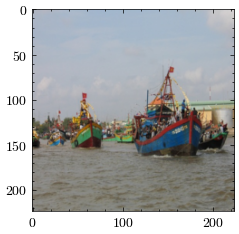

proponents:


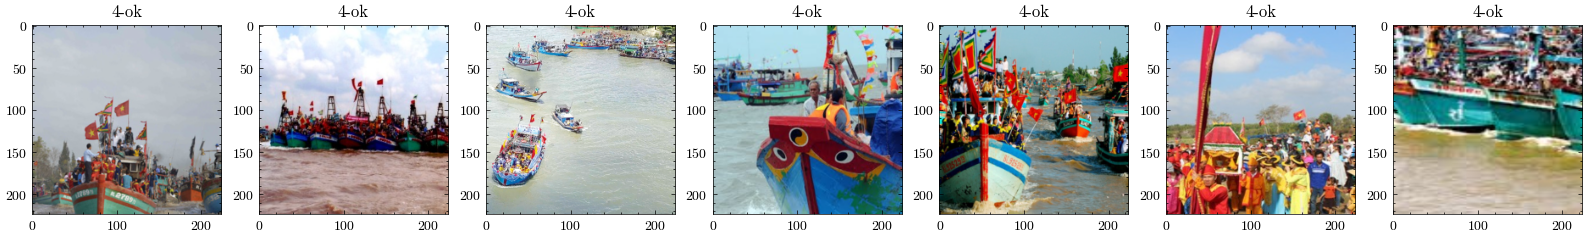

opponents:


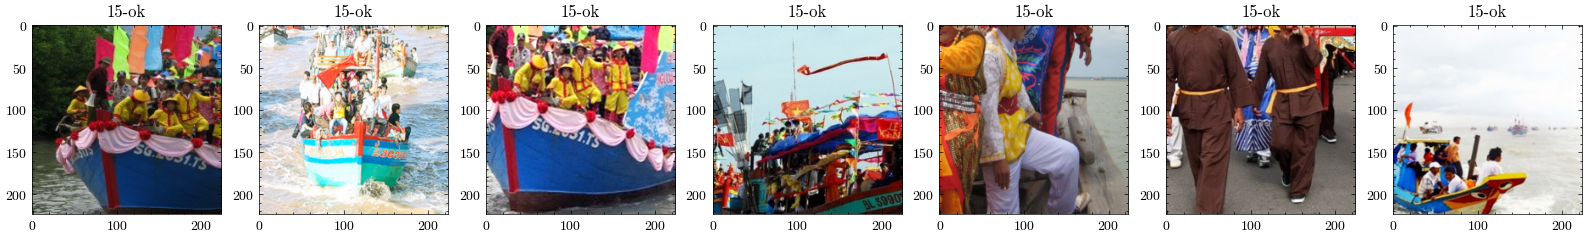

test example:
true_class: 11-ok
predicted_class: 11-ok
predicted_prob 0.9872140884399414


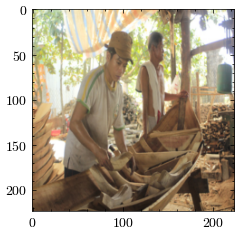

proponents:


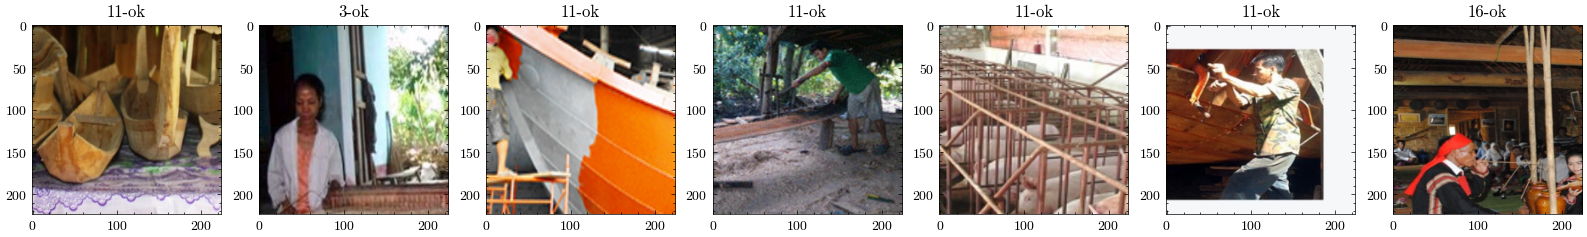

opponents:


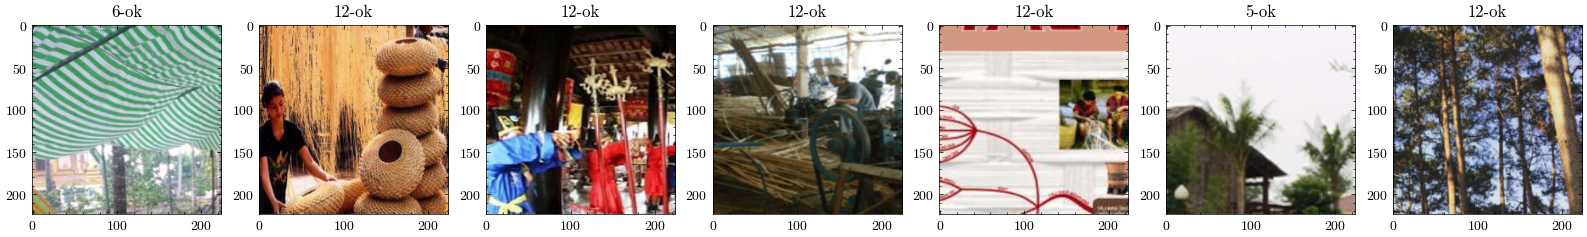

test example:
true_class: 1-ok
predicted_class: 1-ok
predicted_prob 0.9777788519859314


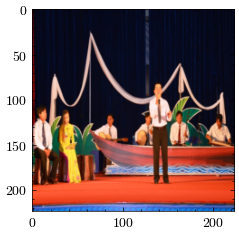

proponents:


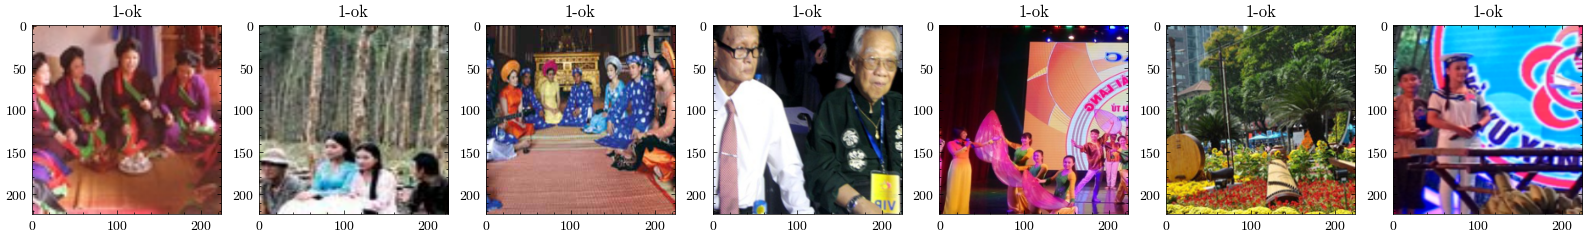

opponents:


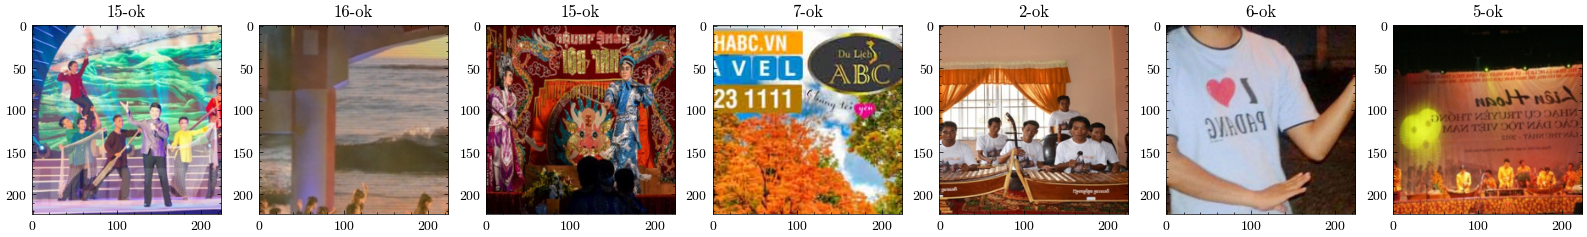

test example:
true_class: 2-ok
predicted_class: 6-ok
predicted_prob 0.6372262239456177


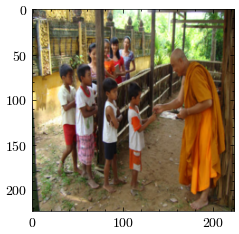

proponents:


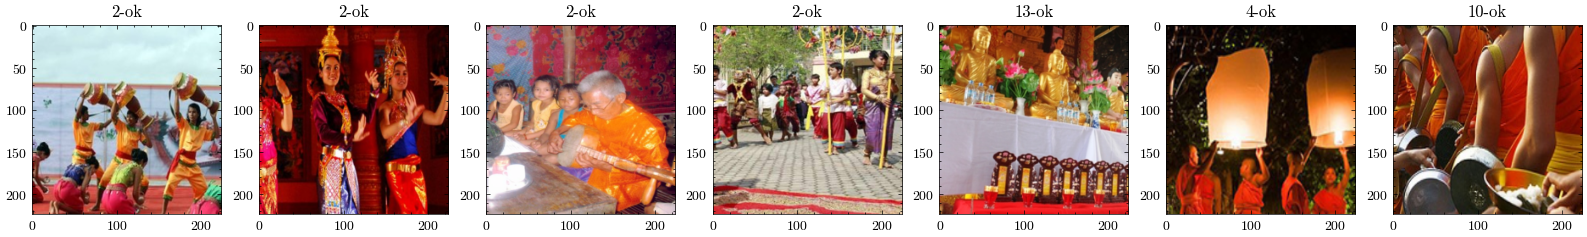

opponents:


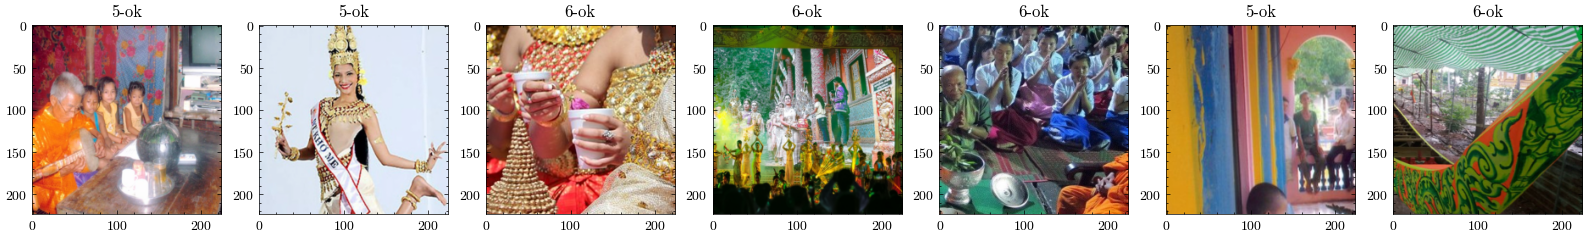

test example:
true_class: 4-ok
predicted_class: 15-ok
predicted_prob 0.8516645431518555


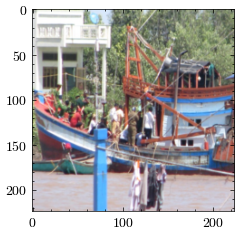

proponents:


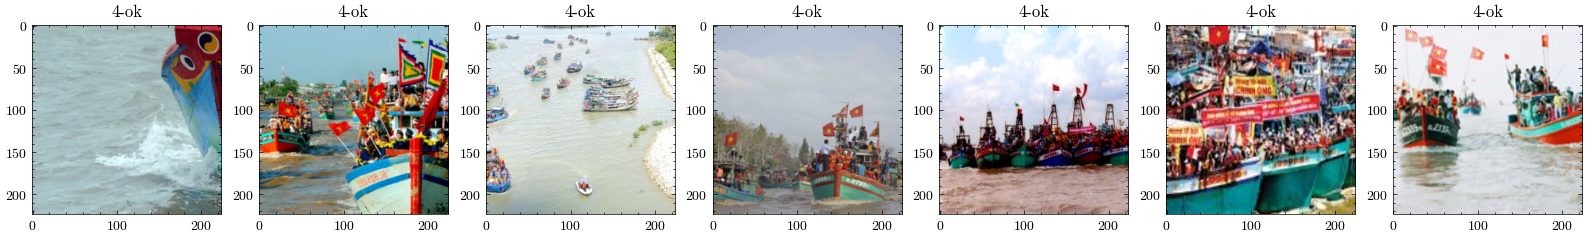

opponents:


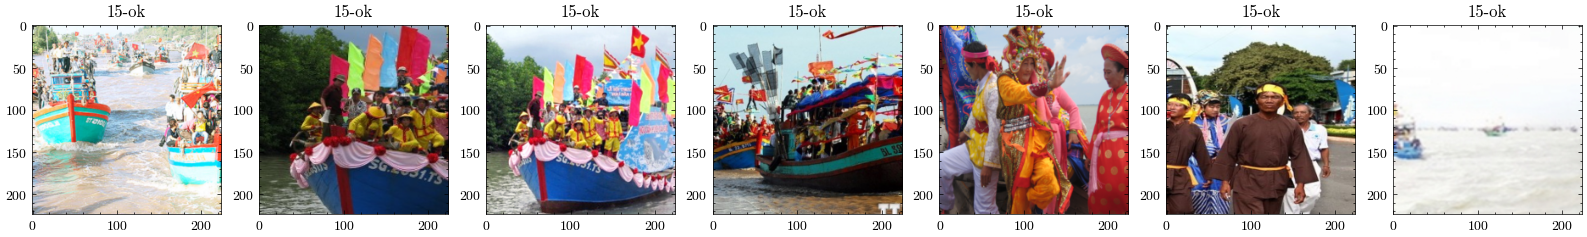

In [27]:
display_proponents_and_opponents(
    test_examples_batch=test_features,
    proponents_indices=proponents_indices,
    opponents_indices=opponents_indices,
    test_examples_true_labels=test_labels,
    test_examples_predicted_labels=test_predicted_labels,
    test_examples_predicted_probs=test_predicted_probs,
)